<h2>IMPORTING THE REQUIRED LIBRARIES AND MODULES</h2>

In [1]:
from getpass import getpass
from mysql.connector import connection

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

from IPython import display

<h2>CREATING A CONNECTION BETWEEN OUR JUPYTER NOTEBOOK AND MYSQL. SELECTING THE SAKILA DATABASE</h2>

In [2]:
def mysql_database_connection(user, host, database):

    password = getpass()

    mysql_connection = connection.MySQLConnection(user = user, password = password,
                                                  host = host, database = database)
                                     
    return mysql_connection

sakila_engine = mysql_database_connection('root', 'localhost', 'sakila')

<h2>JOINING ALL THE DATA FROM THE FILM AND RENTAL COLUMNS</h2>

In [3]:
def film_inventory_rental(query, engine):

    return pd.read_sql_query(query, engine)

query = '''SELECT * FROM 
           film f JOIN inventory i USING(film_id)
           JOIN rental r ON i.inventory_id = r.inventory_id
           WHERE YEAR(r.rental_date) = 2005'''

film_inventory_rental_data = film_inventory_rental(query, sakila_engine)

<h2>REMOVING THE ID AND THE UPDATE COLUMNS - REMOVING THE RETURN DATE COLUMN TOO BECAUSE OF THE DATA LEAKAGE</h2>

In [4]:
def drop_id_update_return_columns(dataframe):

    columns_to_drop = list()

    for column in dataframe.columns:
        if 'id' in column or 'update' in column:
            columns_to_drop.append(column)

    columns_to_drop.append('return_date') 

    dataframe = dataframe.drop(columns_to_drop, axis = 1)

    return dataframe

film_inventory_rental_data = drop_id_update_return_columns(film_inventory_rental_data)

<h2>REMOVING THE TITLE AND THE DESCRIPTION COLUMNS</h2>

In [5]:
def drop_title_description_column(dataframe, column):

    return dataframe.drop(column, axis = 1)

film_inventory_rental_data = drop_title_description_column(film_inventory_rental_data, 'description')

<h2>DROPPING THE RELEASE YEAR COLUMN BECAUSE IT HAS 0 VARIANCE</h2>

In [6]:
def drop_release_year_column(dataframe, column):

    return dataframe.drop(column, axis = 1)

film_inventory_rental_data = drop_release_year_column(film_inventory_rental_data, 'release_year')

<h2>FORMATTING THE SPECIAL FEATURES COLUMN BEFORE USING THE FEATURE</h2>

In [7]:
def order_special_features(x):

    return sorted(x, key = str.lower)

film_inventory_rental_data['special_features'] = film_inventory_rental_data['special_features'].apply(order_special_features)

<h2>MANUALLY ONE HOT ENCODING THE SPECIAL FEATURES COLUMN</h2>

In [8]:
def one_hot_special_features(dataframe, column):

    dataframe['behind_the_scenes'] = 0
    dataframe['commentaries'] = 0
    dataframe['deleted_scenes'] = 0
    dataframe['trailers'] = 0

    def behind_the_scenes(row):

        if 'Behind the Scenes' in row[column]:
            return 1

        return 0

    def commentaries(row):

        if 'Commentaries' in row[column]:
            return 1

        return 0

    def deleted_scenes(row):

        if 'Deleted Scenes' in row[column]:
            return 1

        return 0

    def trailers(row):

        if 'Trailers' in row[column]:
            return 1

        return 0

    dataframe['behind_the_scenes'] = film_inventory_rental_data.apply(behind_the_scenes, axis = 1)
    dataframe['commentaries'] = film_inventory_rental_data.apply(commentaries, axis = 1) 
    dataframe['deleted_scenes'] = film_inventory_rental_data.apply(deleted_scenes, axis = 1)
    dataframe['trailers'] = film_inventory_rental_data.apply(trailers, axis = 1)

    dataframe = dataframe.drop(column, axis = 1)

    return dataframe

film_inventory_rental_data = one_hot_special_features(film_inventory_rental_data, 'special_features')

<h2>EXTRACTING THE TARGET COLUMN: IF THE RENTAL WAS IN AUGUST OR WAS NOT IN AUGUST</h2>

In [9]:
def extract_target_month(dataframe, column, month_column, is_august_column):

    dataframe[month_column] = dataframe[column].dt.month
    dataframe = dataframe.drop(column, axis = 1)

    def is_august(month):

        if month == 8:
            return 1
        
        return 0

    dataframe[is_august_column] = dataframe[month_column].apply(is_august)
    dataframe = dataframe.drop(month_column, axis = 1)

    return dataframe

film_inventory_rental_data = extract_target_month(film_inventory_rental_data, 'rental_date', 'rental_month', 'august_rental')

<h2>DEFINING HOW MANY TIMES THE FILM HAS BEEN RENTED IN AUGUST</h2>

In [10]:
def rentals_in_august(dataframe, column, new_column):

    august_rentals = dataframe[dataframe[column] == 1]
    august_rentals_per_film = august_rentals.groupby('title').agg({'august_rental': len}).reset_index()
    august_rentals_per_film_dict = august_rentals_per_film.set_index('title')['august_rental'].to_dict()
    dataframe[new_column] = dataframe['title'].map(august_rentals_per_film_dict)

    # dataframe = dataframe.drop('title', axis = 1)

    dataframe = dataframe[['title', 'rental_duration', 'rental_rate', 'length', 'replacement_cost',
                           'rating', 'behind_the_scenes', 'commentaries', 'deleted_scenes',
                           'trailers', 'august_rental', 'rentals_in_august']]

    return dataframe

film_inventory_rental_data = rentals_in_august(film_inventory_rental_data, 'august_rental', 'rentals_in_august')

<h2>CONVERTING THE RENTAL DURATION AND THE RENTAL RATE COLUMNS IN OBJECTS</h2>

In [11]:
def numerical_to_categorical(dataframe, columns):

    for column in columns:
        dataframe[column] = dataframe[column].astype('object')

    return dataframe

film_inventory_rental_data = numerical_to_categorical(film_inventory_rental_data, ['rental_duration', 'rental_rate'])

<h2>PERFORMING THE X-Y SPLIT AND THE TRAIN TEST SPLIT</h2>

In [12]:
def x_y_train_test(dataframe, target):

    X = dataframe.drop(target, axis = 1)
    y = dataframe[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

    titles_x_train = X_train['title']
    titles_x_test = X_test['title']

    X_train = X_train.drop('title', axis = 1)
    X_test = X_test.drop('title', axis = 1)

    return X_train, X_test, y_train, y_test, titles_x_train, titles_x_test

X_train, X_test, y_train, y_test, train_titles, test_titles = x_y_train_test(film_inventory_rental_data, 'august_rental')

<h2>SCALING THE NUMERICAL FEATURES</h2>

In [13]:
def scaling(training_x, testing_x, columns):

    training_x_numerical = training_x[columns]
    testing_x_numerical = testing_x[columns]

    scaler = StandardScaler().fit(training_x_numerical)

    training_x_numerical_array = scaler.transform(training_x_numerical)
    training_x_numerical_scaled = pd.DataFrame(data = training_x_numerical_array, columns = training_x_numerical.columns, index = training_x.index)

    testing_x_numerical_array = scaler.transform(testing_x_numerical)
    testing_x_numerical_scaled = pd.DataFrame(data = testing_x_numerical_array, columns = testing_x_numerical.columns, index = testing_x.index)

    numerical_columns = training_x_numerical.columns.to_list()
    training_x[numerical_columns] = training_x_numerical_scaled
    testing_x[numerical_columns] = testing_x_numerical_scaled

    return training_x, testing_x

X_train_scaled, X_test_scaled = scaling(X_train, X_test, ['length', 'replacement_cost', 'rentals_in_august'])

<h2>ONE HOT ENCODING THE CATEGORICAL FEATURES</h2>

In [14]:
def one_hot_encoding(training_x, testing_x, columns):

    training_x_categorical = training_x[columns]
    testing_x_categorical = testing_x[columns]

    training_x = training_x.drop(columns, axis = 1)
    testing_x = testing_x.drop(columns, axis = 1)

    encoder = OneHotEncoder().fit(training_x_categorical)

    total_columns = list()
    columns_to_drop = list()

    for columns in encoder.categories_:
        columns_to_drop.append(columns[0])
        for column in columns:
            total_columns.append(column)

    training_x_categorical_array = encoder.transform(training_x_categorical).toarray()
    training_x_categorical_encoded = pd.DataFrame(data = training_x_categorical_array, columns = total_columns, index = training_x.index)
    training_x_categorical_encoded = training_x_categorical_encoded.drop(columns_to_drop, axis = 1)

    testing_x_categorical_array = encoder.transform(testing_x_categorical).toarray()
    testing_x_categorical_encoded = pd.DataFrame(data = testing_x_categorical_array, columns = total_columns, index = testing_x.index)
    testing_x_categorical_encoded = testing_x_categorical_encoded.drop(columns_to_drop, axis = 1)

    training_x = pd.concat([training_x, training_x_categorical_encoded], axis = 1)
    testing_x = pd.concat([testing_x, testing_x_categorical_encoded], axis = 1)

    return training_x, testing_x

X_train_scaled_encoded, X_test_scaled_encoded = one_hot_encoding(X_train_scaled, X_test_scaled, ['rental_duration', 'rental_rate', 'rating'])

<h2>CREATING AND FITTING A LOGISTIC REGRESSION MODEL. GENERATING PREDICTIONS</h2>

In [15]:
def create_fit_random_forest(training_x, training_y):

    model = RandomForestClassifier()
    model.fit(training_x, training_y)
    
    return model

random_forest = create_fit_random_forest(X_train_scaled_encoded, y_train)
predictions_train = random_forest.predict_proba(X_train_scaled_encoded)
predictions_test = random_forest.predict_proba(X_test_scaled_encoded)

<h2>VISUALIZING THE CONFUSION MATRIX</h2>

<Figure size 432x288 with 0 Axes>

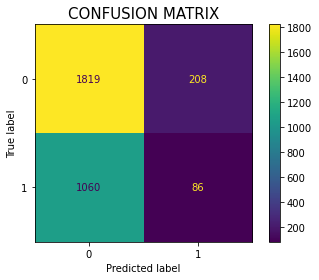

In [16]:
fig = plt.figure()
plot_confusion_matrix(random_forest, X_test_scaled_encoded, y_test)
plt.title('CONFUSION MATRIX', fontsize = 15)
plt.show()

<h2>PROBABILITIES OF RENTING OF THE FILM IN AUGUST PER FILM TITLE</h2>

In [17]:
predictions_train_per_film = pd.DataFrame(data = predictions_train, columns = ['No rent august', 'Yes rent in august'], index = X_train_scaled_encoded.index)
predictions_train_per_film['title'] = train_titles
predictions_train_per_film = predictions_train_per_film[['title', 'No rent august', 'Yes rent in august']]

predictions_test_per_film = pd.DataFrame(data = predictions_test, columns = ['No rent august', 'Yes rent in august'], index = X_test_scaled_encoded.index)
predictions_test_per_film['title'] = test_titles
predictions_test_per_film = predictions_test_per_film[['title', 'No rent august', 'Yes rent in august']]

pd.concat([predictions_train_per_film, predictions_test_per_film]).groupby('title').mean().reset_index()

,title,No rent august,Yes rent in august
0,ACADEMY DINOSAUR,0.483127,0.516873
1,ACE GOLDFINGER,0.412332,0.587668
2,ADAPTATION HOLES,0.470275,0.529725
3,AFFAIR PREJUDICE,0.707398,0.292602
4,AFRICAN EGG,0.660228,0.339772
...,...,...,...
953,YOUNG LANGUAGE,0.540994,0.459006
954,YOUTH KICK,0.507111,0.492889
955,ZHIVAGO CORE,0.818434,0.181566
956,ZOOLANDER FICTION,0.661381,0.338619
